<a href="https://colab.research.google.com/github/Limteckping45/COS30019Assignment2/blob/main/KNN_Evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score
import joblib
from PIL import Image
import matplotlib.pyplot as plt

!git clone "https://github.com/Limteckping45/COS30019Assignment2"

train_data_dir = "/content/COS30019Assignment2/training_dataset"
test_data_dir = "/content/COS30019Assignment2/testing_dataset"
validation_data_dir = "/content/COS30019Assignment2/validation_dataset_1"

# Define image dimensions
img_width, img_height = 224, 224
input_shape = (img_width, img_height, 3)
batch_size = 32

# Pre-process and augment data
datagen = ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)

test_generator = datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)

validation_generator = datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)

# Load pre-trained DenseNet121 model without top layers
base_model = DenseNet121(weights="imagenet", include_top=False, input_shape=input_shape)

# Extract features from train, validation, and test data
def extract_features(generator, sample_count):
    features = np.zeros(shape=(sample_count, 7, 7, 1024))  # DenseNet121 output shape
    labels = np.zeros(shape=(sample_count, generator.num_classes))

    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = base_model.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break

    return features, labels

train_features, train_labels = extract_features(train_generator, train_generator.samples)
validation_features, validation_labels = extract_features(validation_generator, validation_generator.samples)
test_features, test_labels = extract_features(test_generator, test_generator.samples)

# Flatten extracted features
train_features = np.reshape(train_features, (train_generator.samples, 7 * 7 * 1024))
validation_features = np.reshape(validation_features, (validation_generator.samples, 7 * 7 * 1024))
test_features = np.reshape(test_features, (test_generator.samples, 7 * 7 * 1024))

# Convert labels from one-hot encoding to label encoding
train_labels = np.argmax(train_labels, axis=1)
validation_features = np.reshape(validation_features, (validation_generator.samples, 7 * 7 * 1024))
test_labels = np.argmax(test_labels, axis=1)

# Train KNN
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(train_features, train_labels)

# Save the KNN model
joblib.dump(knn_model, 'knn_animal_breed_classifier.pkl')

fatal: destination path 'COS30019Assignment2' already exists and is not an empty directory.
Found 1920 images belonging to 12 classes.
Found 1200 images belonging to 12 classes.
Found 120 images belonging to 12 classes.
1/1 [==============================] - 2s 2s/step


['knn_animal_breed_classifier.pkl']

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import joblib
import plotly.figure_factory as ff

# Clone the repository
!git clone "https://github.com/Limteckping45/COS30019Assignment2"

# Directory paths for the dataset
test_data_dir = "/content/COS30019Assignment2/testing_dataset"

# Define image dimensions
img_width, img_height = 224, 224
input_shape = (img_width, img_height, 3)
batch_size = 32

# Pre-process the test data
datagen = ImageDataGenerator(rescale=1./255)

test_generator = datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)

# Extract class names from the test generator
class_names = list(test_generator.class_indices.keys())

# Load the pre-trained DenseNet121 model without top layers for feature extraction
base_model = DenseNet121(weights="imagenet", include_top=False, input_shape=input_shape)

# Extract features from the test data
def extract_features(generator, sample_count):
    features = np.zeros(shape=(sample_count, 7, 7, 1024))  # DenseNet121 output shape
    labels = np.zeros(shape=(sample_count, generator.num_classes))

    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = base_model.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break

    return features, labels

test_features, test_labels = extract_features(test_generator, test_generator.samples)

# Flatten extracted features
test_features = np.reshape(test_features, (test_generator.samples, 7 * 7 * 1024))

# Convert labels from one-hot encoding to label encoding
test_labels = np.argmax(test_labels, axis=1)

# Load the saved KNN model
knn_model = joblib.load('knn_animal_breed_classifier.pkl')

# Predict test data using the loaded KNN model
test_predictions = knn_model.predict(test_features)

# Calculate the test accuracy
test_accuracy = accuracy_score(test_labels, test_predictions)
print("Test Accuracy:", test_accuracy)

# Calculate confusion matrix
conf_matrix = confusion_matrix(test_labels, test_predictions)

# Plot the confusion matrix using Plotly
fig = ff.create_annotated_heatmap(
    z=conf_matrix,
    x=class_names,
    y=class_names,
    colorscale='Blues',
    showscale=True
)

fig.update_layout(
    title='Confusion Matrix',
    xaxis=dict(title='Predicted Labels'),
    yaxis=dict(title='True Labels')
)

fig.show()

# Create a simple neural network to evaluate loss and accuracy
num_classes = len(class_names)

# Convert predictions to one-hot encoding
test_predictions_one_hot = tf.keras.utils.to_categorical(test_predictions, num_classes)
test_labels_one_hot = tf.keras.utils.to_categorical(test_labels, num_classes)

# Define a simple model to calculate loss and accuracy
input_layer = tf.keras.layers.Input(shape=(7 * 7 * 1024,))
output_layer = tf.keras.layers.Dense(num_classes, activation='softmax')(input_layer)
evaluation_model = tf.keras.models.Model(inputs=input_layer, outputs=output_layer)

# Compile the model
evaluation_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model on the KNN predictions to calculate the loss and accuracy
evaluation_model.fit(test_features, test_predictions_one_hot, epochs=1, verbose=0)

# Evaluate the model using the actual test labels
evaluation_results = evaluation_model.evaluate(test_features, test_labels_one_hot, verbose=0)

print("Evaluation Results:")
print(f"Loss: {evaluation_results[0]}")
print(f"Accuracy: {evaluation_results[1]}")

fatal: destination path 'COS30019Assignment2' already exists and is not an empty directory.
Found 1200 images belonging to 12 classes.
1/1 [==============================] - 4s 4s/step
Test Accuracy: 0.8441666666666666


Evaluation Results:
Loss: 1.795952320098877
Accuracy: 0.8433333039283752


fatal: destination path 'COS30019Assignment2' already exists and is not an empty directory.
Found 1200 images belonging to 12 classes.
1/1 [==============================] - 5s 5s/step
Test Accuracy: 0.8441666666666666


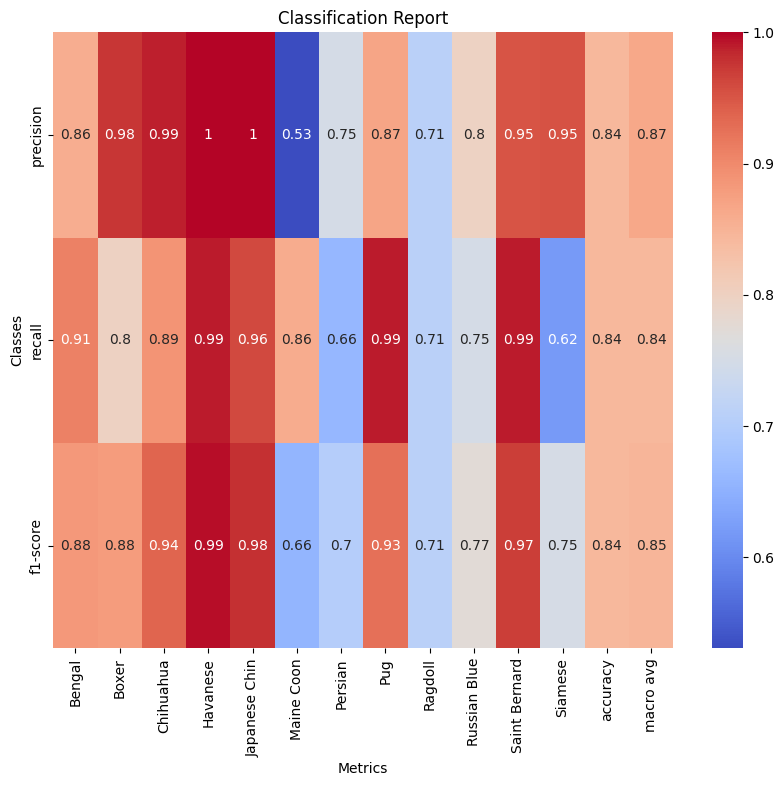

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score
import joblib
from PIL import Image
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

!git clone "https://github.com/Limteckping45/COS30019Assignment2"

# Directory paths for the dataset
test_data_dir = "/content/COS30019Assignment2/testing_dataset"

# Define image dimensions
img_width, img_height = 224, 224
input_shape = (img_width, img_height, 3)
batch_size = 32

# Pre-process the test data
datagen = ImageDataGenerator(rescale=1./255)

test_generator = datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)

# Extract class names from the test generator
class_names = list(test_generator.class_indices.keys())

# Load the pre-trained DenseNet121 model without top layers for feature extraction
base_model = DenseNet121(weights="imagenet", include_top=False, input_shape=input_shape)

# Extract features from the test data
def extract_features(generator, sample_count):
    features = np.zeros(shape=(sample_count, 7, 7, 1024))  # DenseNet121 output shape
    labels = np.zeros(shape=(sample_count, generator.num_classes))

    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = base_model.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break

    return features, labels

test_features, test_labels = extract_features(test_generator, test_generator.samples)

# Flatten extracted features
test_features = np.reshape(test_features, (test_generator.samples, 7 * 7 * 1024))

# Convert labels from one-hot encoding to label encoding
test_labels = np.argmax(test_labels, axis=1)

# Load the saved KNN model
knn_model = joblib.load('knn_animal_breed_classifier.pkl')

# Predict test data using the loaded KNN model
test_predictions = knn_model.predict(test_features)

# Calculate the test accuracy
test_accuracy = accuracy_score(test_labels, test_predictions)
print("Test Accuracy:", test_accuracy)

# Generate the classification report
report = classification_report(test_labels, test_predictions, target_names=class_names, output_dict=True)

# Convert the classification report to a DataFrame
report_df = pd.DataFrame(report).transpose()

# Remove support column for visualization
report_df = report_df.drop(columns=['support'])

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(report_df.iloc[:-1, :].T, annot=True, cmap="coolwarm", cbar=True)
plt.title("Classification Report")
plt.xlabel("Metrics")
plt.ylabel("Classes")
plt.show()